# Project Overview

Our project's goal was to cluster meteorological data of cities in Emilia Romagna. We conducted grouping of time series with the
 K-Means algorithm. The number of clusters was decided based on the Silhouette and Inertia measurments

# Importing, data cleaning and filtering

```python

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

script_path = os.getcwd()
path = os.path.dirname(script_path)

def import_data(path):
    data = R'data'
    data_path = os.path.join(path, data)
    
    # List all files in the folder
    csv_files = [file for file in os.listdir(data_path) if file.endswith(".csv") if file != 'InfoComune.csv']

    # Create an empty dictionary to store DataFrames
    dataframes = {}

    # Iterate through each CSV file
    for file in csv_files:
        # Extract the file name
        df_name = os.path.splitext(file)[0]
        
        # Create the DataFrame and store it in the dictionary
        dataframes[df_name] = pd.read_csv(os.path.join(data_path, file), header=0, skiprows = [1])
        
    return dataframes


dataframes = import_data(path)

# store dictionary items in specific variables to make it easier to loop through them
datasets = dataframes.values()
provinces = dataframes.keys()
data_prov_pairs = dataframes.items()

# columns to keep the average value only
pollutants = ['CO', 'NH3', 'NMVOC', 'NO2', 'NO', 'O3', 'PANS', 'PM10', 'PM2.5', 'SO2']

# metereological information
met = ['TG', 'TN', 'TX', 'HU', 'PP', 'QQ', 'RR']
met_pos = range(6, 13)
# date values
date = ['YYYY', 'MM', 'DD']
date_pos = list(range(3))

selected_columns = date + met + pollutants

numerics = met + pollutants

def clean_data(data):
    for province, df in data_prov_pairs:
        # change missing values to the proper format
        df.replace('---', np.nan, inplace = True)
        # ensure a unique format
        df = df.convert_dtypes()

        # rename the columns for date and metereological information
        old_date = df.columns[date_pos]
        old_met = df.columns[met_pos]
        
        df.rename(columns=dict(zip(old_date, date)), inplace=True)
        df.rename(columns=dict(zip(old_met, met)), inplace=True)
                
        df = df[selected_columns]

        # Combine 'YYYY', 'MM', 'DD' columns into a new 'date' column
        df['date'] = pd.to_datetime(df[['YYYY', 'MM', 'DD']].astype(str).agg('-'.join, axis=1), format='%Y-%m-%d')
        
        # Remove 'YYYY', 'MM', 'DD' columns
        df.drop(['YYYY', 'MM', 'DD'], axis=1, inplace=True)
                
        # Reorder columns with 'date' as the first column
        df = df[['date'] + [col for col in df.columns if col != 'date']]
        
        # first convert to numeric the columns in met and pollutants, since they are strings
        df[numerics] = df[numerics].apply(pd.to_numeric, errors = 'coerce')
        # round to the second decimal number for better visualization
        df[numerics] = df[numerics].round(2)
        
        # we want to filter the series so that we don't have missing values
        # We'll start from 2018-01-01 and move until 2020-12-28

        df = df[(df['date'] >= pd.to_datetime('2018-01-01')) & (df['date'] <= pd.to_datetime('2020-12-28'))]
        
        dataframes[province] = df

    return dataframes

dataframes = clean_data(dataframes)

# Visualization 

```python
%run setup.py

dataframes['bologna'][dataframes['bologna'].isnull().any(axis=1)]

```python

def impute_median(data):
    from sklearn.impute import SimpleImputer

    imputer = SimpleImputer(strategy='median')

    for province, df in data_prov_pairs:
        df[numerics] = imputer.fit_transform(df[numerics])
        
        dataframes[province] = df
    
    return dataframes



from scipy.signal import savgol_filter

def smooth(window, window_pp, poly_pp, poly = 2):
        
    for province, df in data_prov_pairs:
        
        for column in df[numerics].columns:
            # Extract numerical values from the DataFrame
            values = df[column].values
            
            # Apply Savitzky-Golay filter to the numerical values
            # for PP we need higher smooting due to outliers
            if column == 'PP':
                window = window_pp
                poly = poly_pp
                
            smoothed_values = savgol_filter(values, window, poly)
            # Update the DataFrame with the smoothed values
            df[column] = smoothed_values
            
        dataframes[province] = df

smooth(window = 10, window_pp = 25, poly_pp = 5)




def concat_group(groups, group_name: str):
    # Create an empty list to store modified dataframes
    dfs = []

    # Iterate through the dictionary values and groups labels
    for df, group in zip(datasets, groups):
        
        # Add a 'group' column
        df[group_name] = group
        
        # Append the modified dataframe to the list
        dfs.append(df)
    
    # Concatenate all dataframes in the list along the rows
    full_df = pd.concat(dfs, ignore_index=True)
    full_df
    
    return full_df



def plot_group(subfolder: str, vars, group: str, full_df):
    # subfolder should be a string indicating the name of the subfolder in the figures_folder
    # vars should be the list containing the variable names, therefore either pollutants, mets, numerics
    # group should be the variable we want to group by (eg: province, clusters,...)
    # to group we need to have created the full dataframe before with the specific group variable
    
    sns.set(style="whitegrid")
    figures = R'figures'
    figures_folder = os.path.join(path, figures)
    output_folder = os.path.join(figures_folder, subfolder)
    os.makedirs(output_folder, exist_ok=True)

    for var in vars:
        
        # Plot the time series for each province
        plt.figure(figsize=(12, 6))
        sns.lineplot(x='date', y=var, hue=full_df[group], data=full_df)

        plt.title(f'Meteorological Information Over Time by {group}')
        plt.xlabel('Date')
        plt.ylabel(var)
        plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
        
        save_path = os.path.join(output_folder, f'{var}.png')
        plt.savefig(save_path, bbox_inches='tight')
        
        plt.show()

```python

plot_group('smooth_series', numerics, 'province', full_df)
```

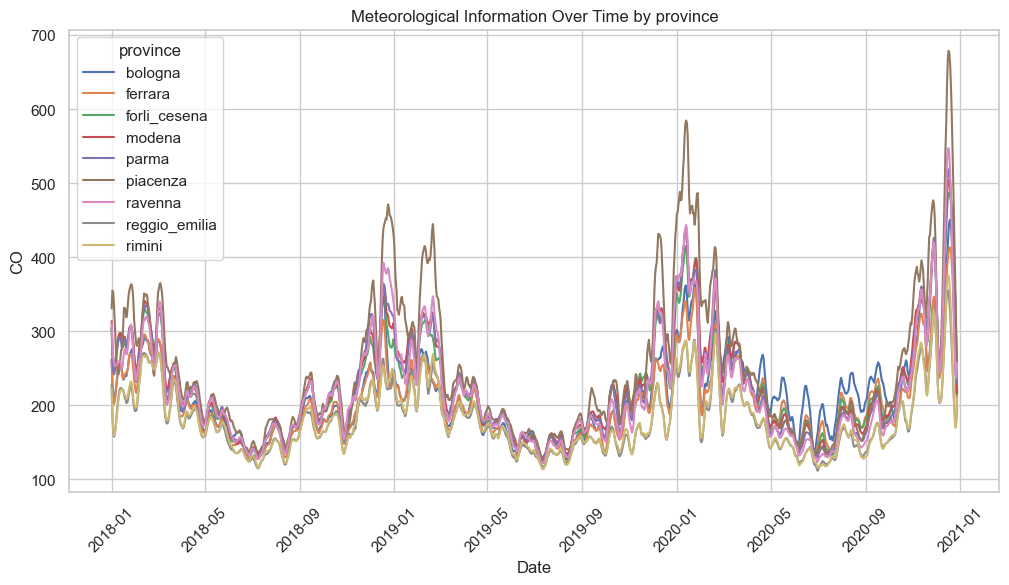
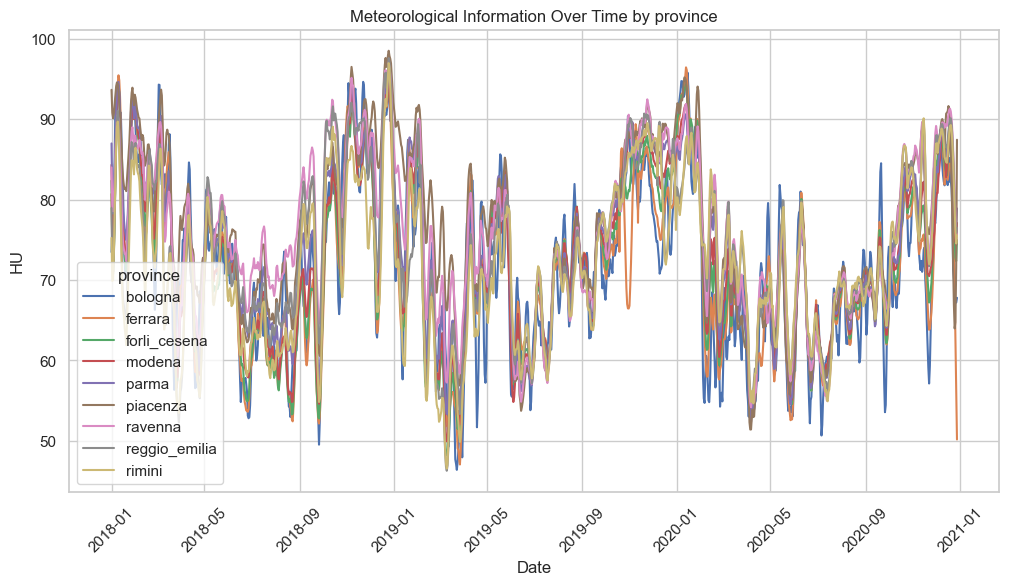
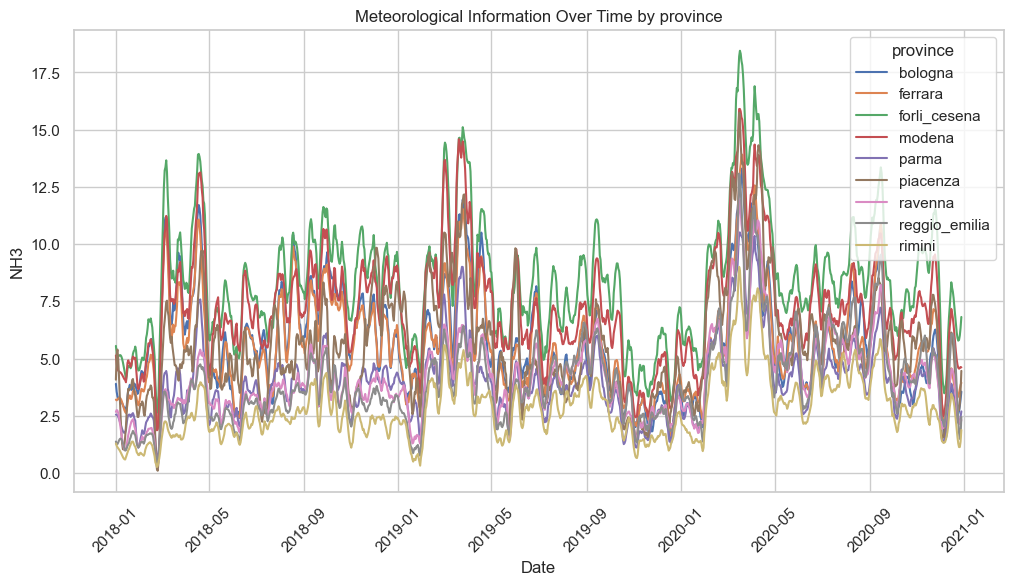
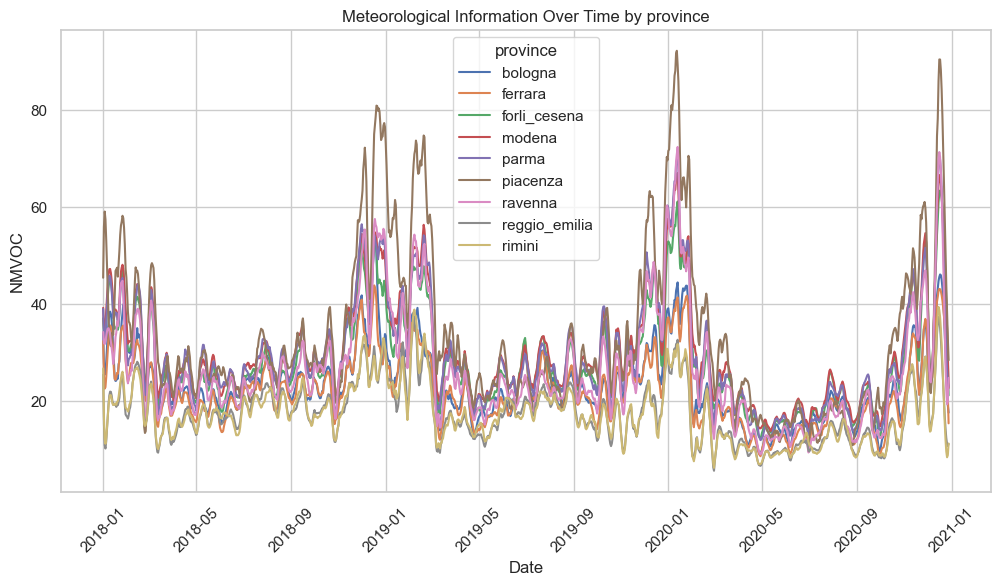
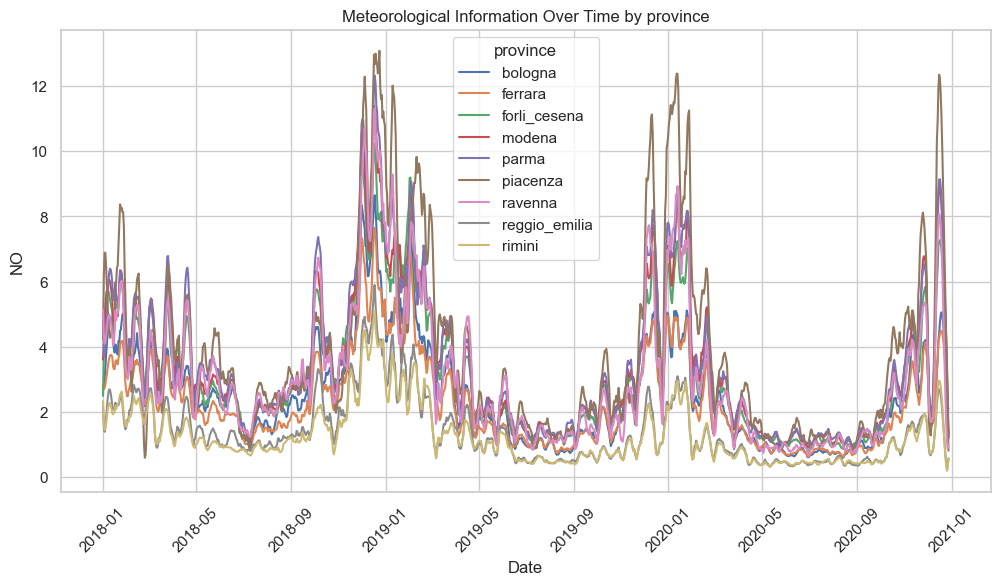
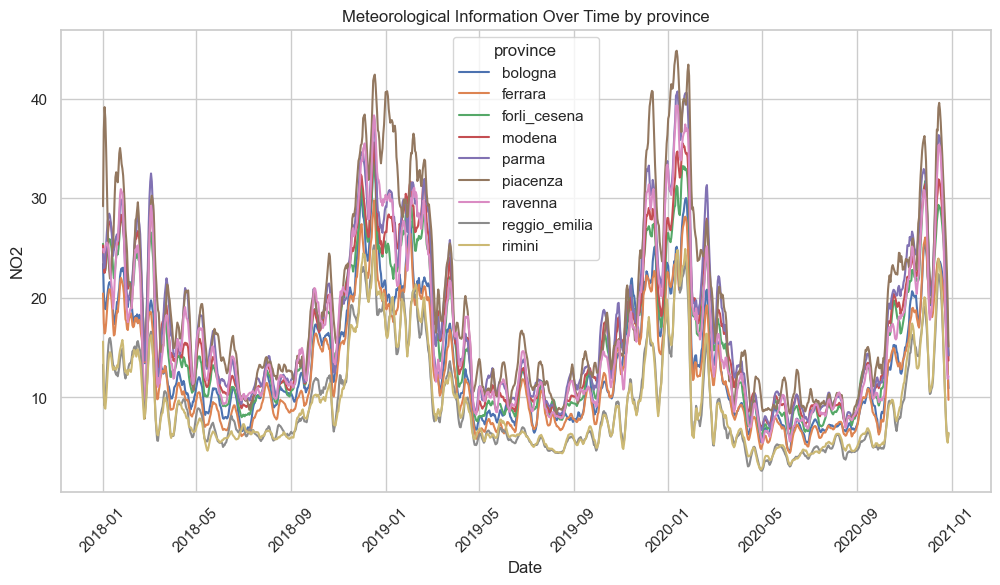
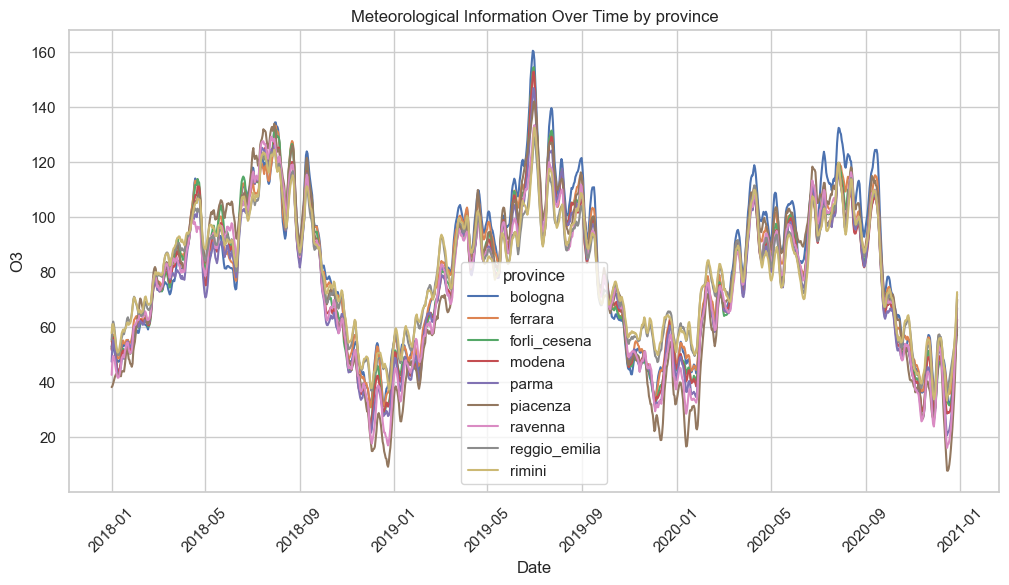
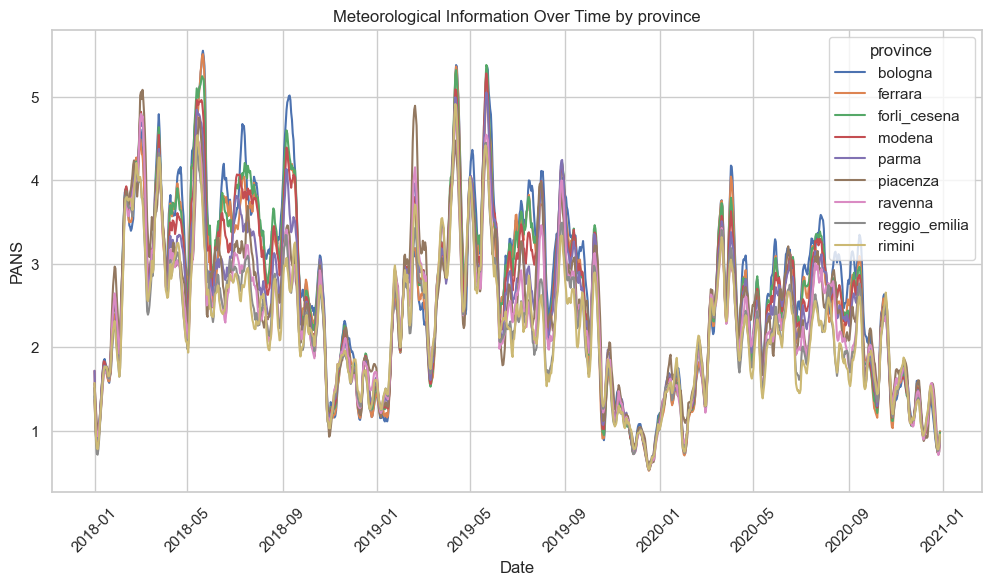
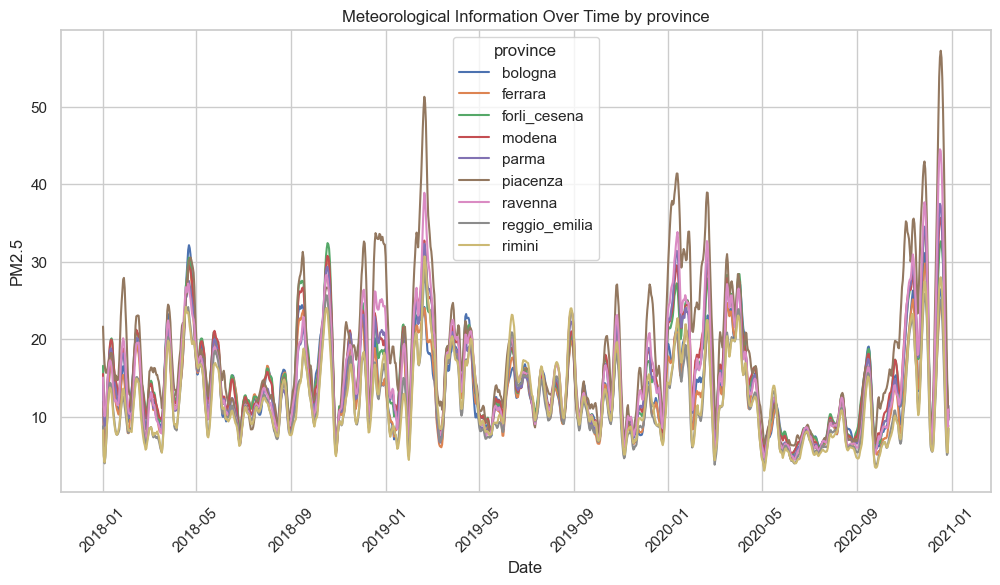
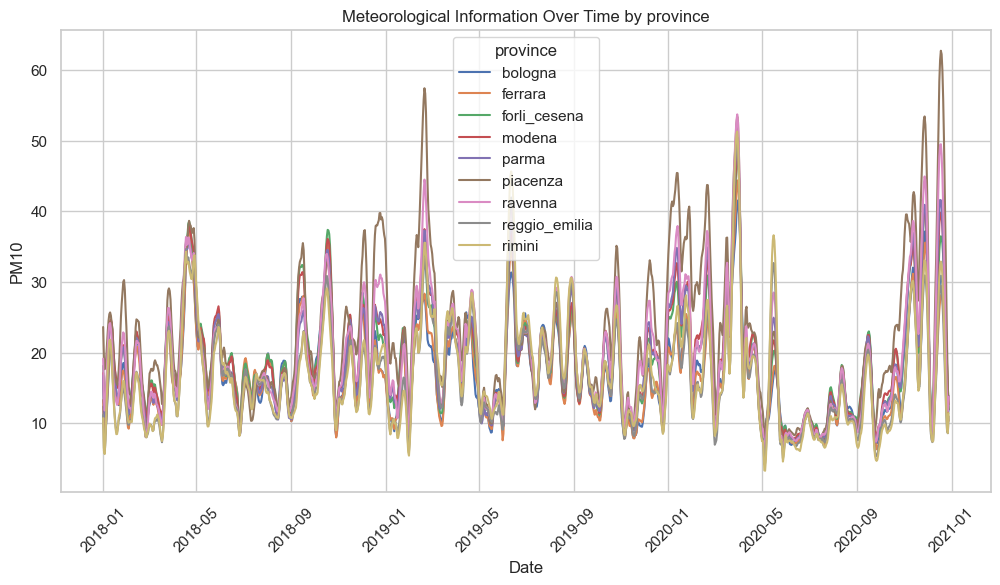
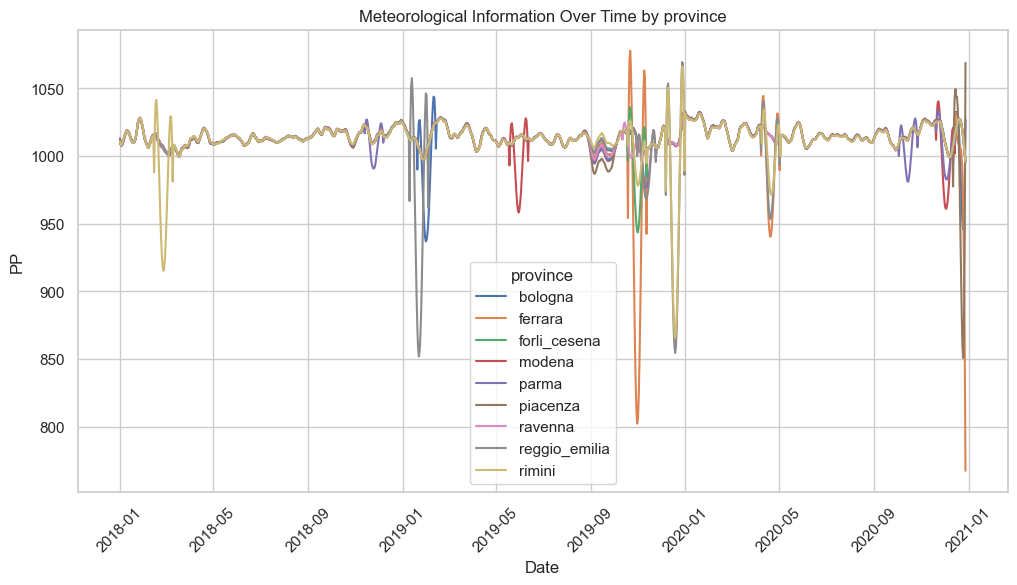
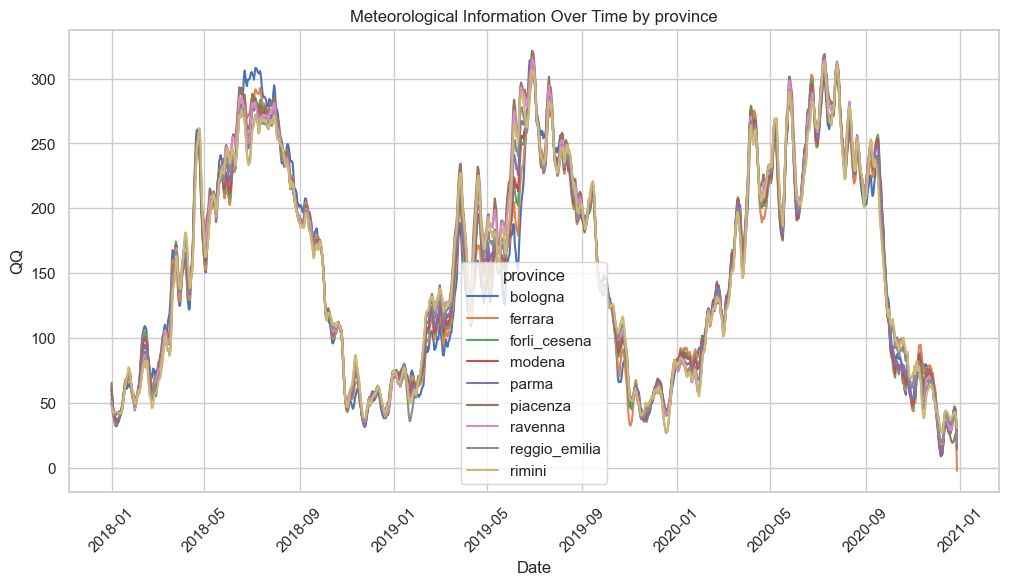
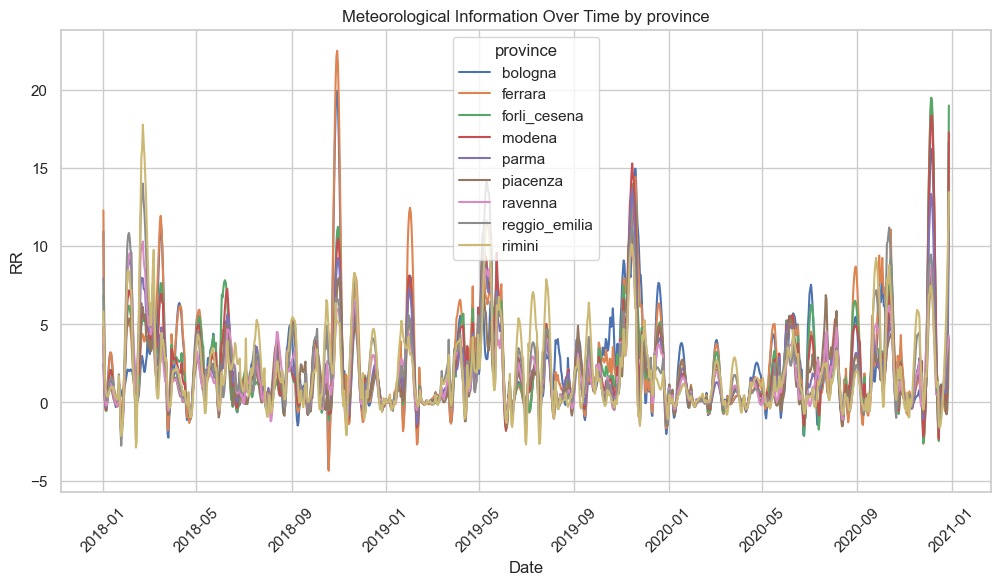
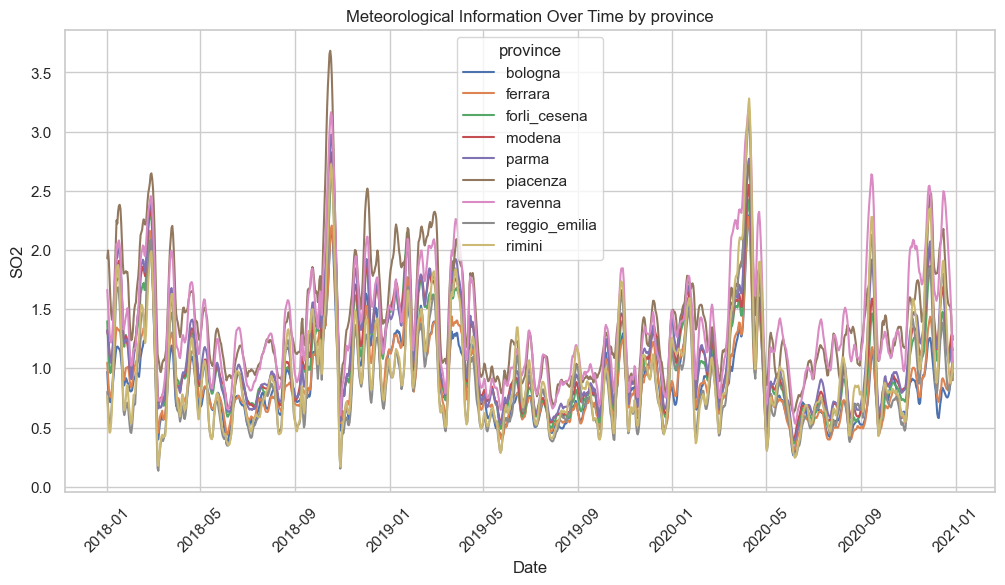
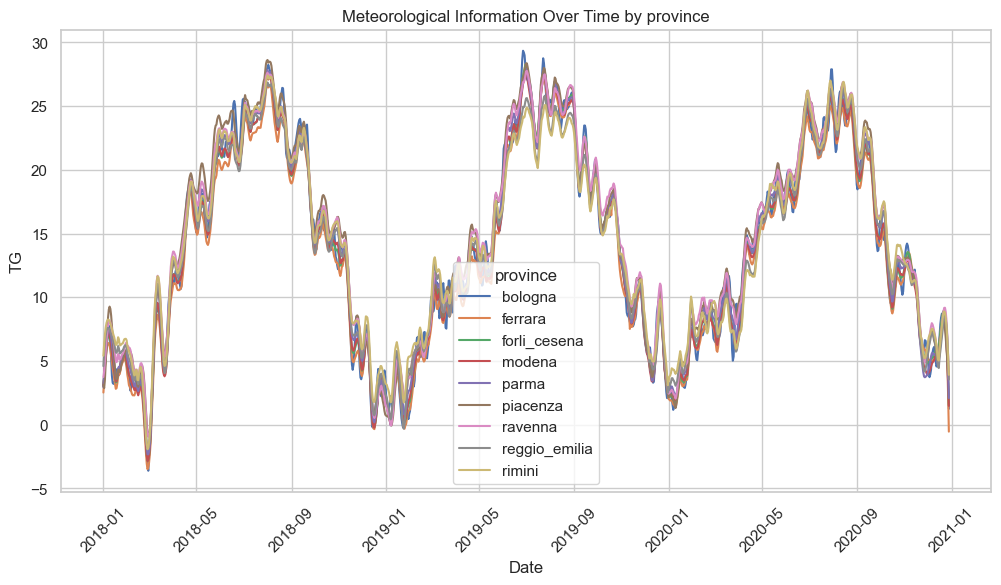
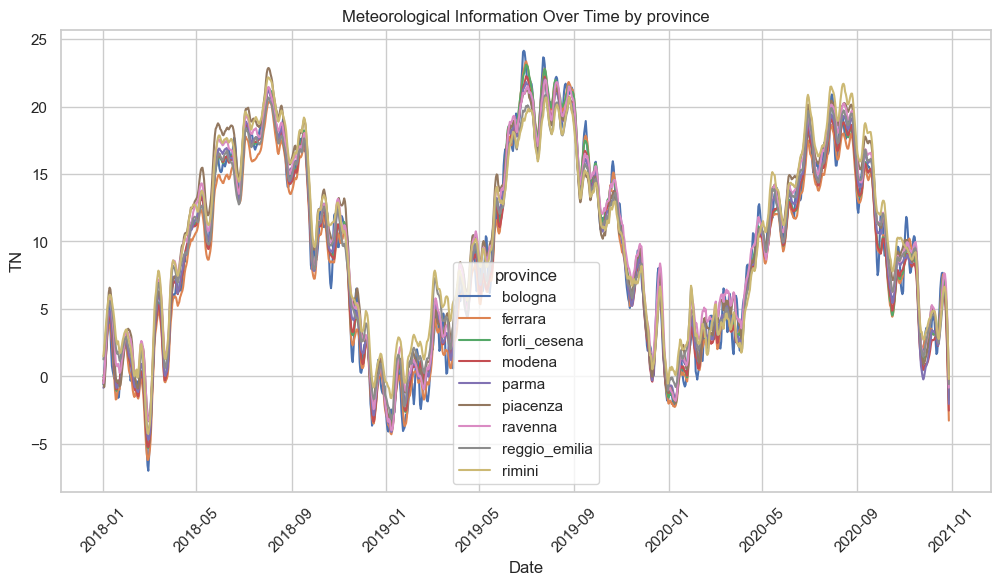
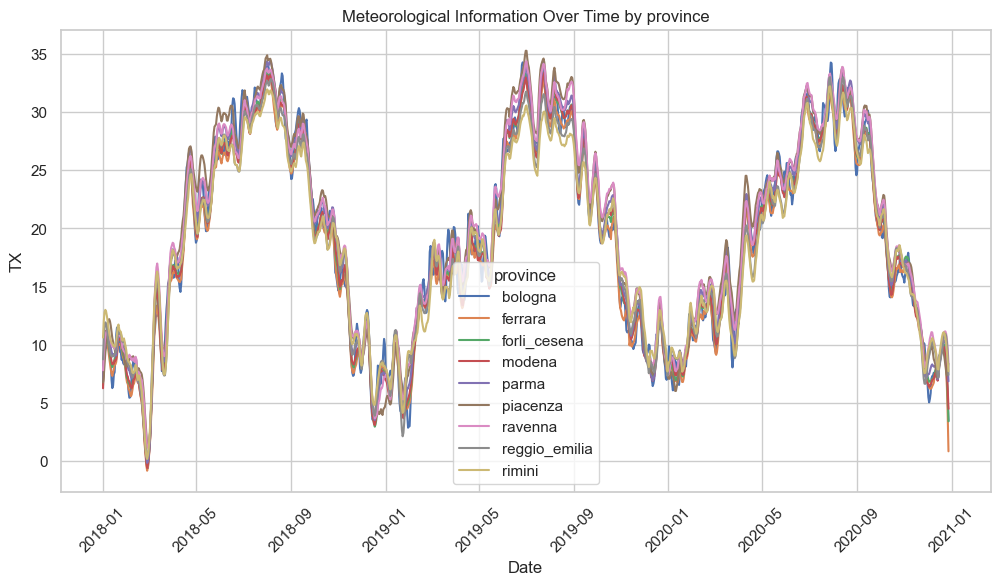


# K-Means clustering

```python

from tslearn.clustering import TimeSeriesKMeans, silhouette_score
from sklearn.preprocessing import MinMaxScaler

# let's normalize the numerical features of the dataframe
for df in datasets:
    df[numerics] = MinMaxScaler().fit_transform(df[numerics])

# Prepare input data
X = []

for df in datasets:
    group_data = df[pollutants].values
    
    # Reshape to (n_samples, n_timestamps, n_features)
    group_data = np.expand_dims(group_data, axis=0)
    X.append(group_data)

# Stack the list of arrays to create a 3D array
X = np.vstack(X)

inertia = []
silhouette = []
K = list(range(2, 9))

for k in K:
    km = TimeSeriesKMeans(n_clusters=k, n_init=5, metric='dtw', random_state=0)
    
    labels = km.fit_predict(X)
    
    silhouette_avg = silhouette_score(X, labels, metric='dtw')
    
    inertia.append(km.inertia_)
    silhouette.append(silhouette_avg)


# Plotting inertia vs slihouette
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(K, inertia, marker='o')
plt.title('Inertia vs. Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')

plt.subplot(1, 2, 2)
plt.plot(K, silhouette, marker='o')
plt.title('Silhouette Score vs. Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')

plt.tight_layout()
figures_folder = os.path.join(path, R'figures')
plt.savefig(os.path.join(figures_folder, 'inertia_silhouette.png'))
plt.show()

```

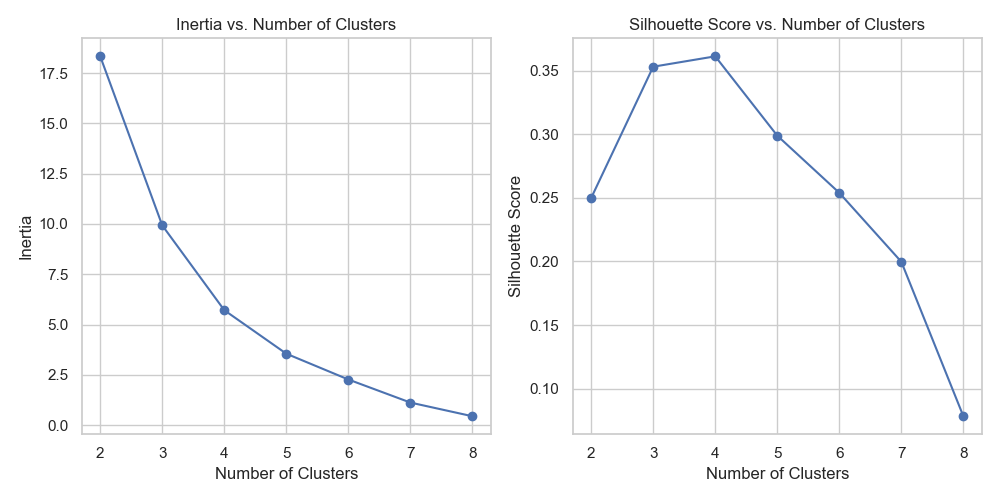


```python
km4 = TimeSeriesKMeans(n_clusters=4, n_init=5, metric='dtw', random_state=0)
clusters = km4.fit_predict(X)

# Specify the results folder
results = R"results"
results_folder = os.path.join(path, results)


def table_clusters(provinces = provinces, clusters = clusters):

    # Create a DataFrame
    cluster_df = pd.DataFrame(list(zip(provinces, clusters)), columns=['Province', 'Cluster'])
    
    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(5, 5))

    # Hide the axes
    ax.axis('off')

    # Create a table and add it to the axis
    table = ax.table(cellText=cluster_df.values, colLabels=cluster_df.columns,
                    cellLoc='center', loc='center', edges = 'open')

    # Make column labels bold
    for (i, j), cell in table.get_celld().items():
        if i == 0:
            cell.set_text_props(fontweight='bold')

    # Adjust column width
    table.auto_set_column_width([0, 1])

    # Adjust the position of the table within the figure
    table.set_fontsize(13)  # Adjust font size
    table.scale(1, 2)  # Scale the table

    ax.set_title(f'Clustering provinces', fontsize=18, y=0.95)  # Add a title

    save_file = os.path.join(results_folder, 'cluster_provinces.png')
    # Save the figure as a PNG image in the specified folder
    fig.savefig(save_file, bbox_inches='tight', pad_inches=0.5, dpi=300)


```python
table_clusters()
```
![clustering provinces.png](<attachment:clustering provinces.png>)
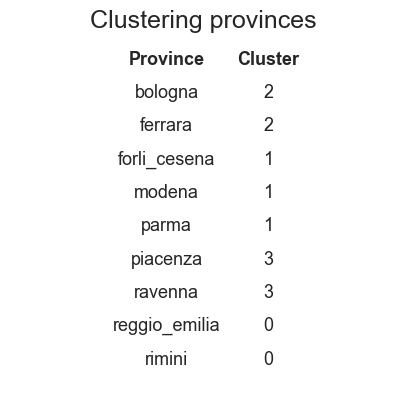

```python
# pre-plots combines multiple DataFrames into a single DataFrame with an added 'province' column.
def pre_plots(groups, group_name: str):
    # Create an empty list to store modified dataframes
    dfs = []

    # Iterate through the dictionary values and groups labels
    for df, group in zip(datasets, groups):
        
        # Add a 'group' column
        df[group_name] = group
        
        # Append the modified dataframe to the list
        dfs.append(df)
    
    # Concatenate all dataframes in the list along the rows
    full_df = pd.concat(dfs, ignore_index=True)
    full_df
    
    return full_df

```python
full_df = pre_plots(clusters, 'cluster')
#df che ha serie storiche fino a una certa data e una variabile categorica che specifica il cluster


#group df by cluster
grouped_df = full_df[['cluster'] + pollutants].groupby('cluster')
summary_stats = grouped_df.describe()

for i in pollutants:
    print(f'Variable:{i}')
    #f states 'in this string i format the i-variable'
    display(summary_stats[i])

<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>count</th>
      <th>mean</th>
      <th>std</th>
      <th>min</th>
      <th>25%</th>
      <th>50%</th>
      <th>75%</th>
      <th>max</th>
    </tr>
    <tr>
      <th>cluster</th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>2186.0</td>
      <td>0.269193</td>
      <td>0.176779</td>
      <td>0.0</td>
      <td>0.137289</td>
      <td>0.227162</td>
      <td>0.368726</td>
      <td>1.0</td>
    </tr>
    <tr>
      <th>1</th>
      <td>3279.0</td>
      <td>0.253108</td>
      <td>0.183578</td>
      <td>0.0</td>
      <td>0.116256</td>
      <td>0.210397</td>
      <td>0.365089</td>
      <td>1.0</td>
    </tr>
    <tr>
      <th>2</th>
      <td>2186.0</td>
      <td>0.269820</td>
      <td>0.171977</td>
      <td>0.0</td>
      <td>0.141271</td>
      <td>0.243246</td>
      <td>0.370814</td>
      <td>1.0</td>
    </tr>
    <tr>
      <th>3</th>
      <td>2186.0</td>
      <td>0.225840</td>
      <td>0.170942</td>
      <td>0.0</td>
      <td>0.101172</td>
      <td>0.178409</td>
      <td>0.311871</td>
      <td>1.0</td>
    </tr>
  </tbody>
</table>
</div>